In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [29]:
class ArrClass:
    def __init__(self):
        self.numAntenna = 3
        self.samps = 300
        self.fs = 100
        self.f = 20
        self.snr = 20
    

def genArrayVec(numAntenna:int, theta:float) -> np.ndarray: 
    return np.array([np.exp(-2j*np.pi*.5*np.sin(theta) * i) for i in range(numAntenna)])

def genData(numAntenna:int, samps:int, fs:float, f:float, theta:float) -> np.ndarray:
    a = genArrayVec(numAntenna=numAntenna, theta=theta)
    t = np.arange(samps)/fs + np.random.randn(1)
    tx = np.exp(2j * np.pi * t * f)
    a = a.reshape(-1, 1)
    tx = tx.reshape(-1, 1)
    return a @ tx.T

def genSweep(arrClass:ArrClass, dimm:int, start:int=0, end:int=90, step:int=1):
    for i in np.arange(start, end, step):
        xs = genData(arrClass.numAntenna, arrClass.samps, arrClass.fs, arrClass.f, i*(np.pi/180))
        noise = (np.random.randn(xs.shape[0], xs.shape[1]) + np.random.randn(xs.shape[0], xs.shape[1]) * 1j) * 10**(-arrClass.snr/10)
        xs = xs + noise
        xs = xs.T.reshape(-1, dimm)
        xs = np.concatenate((xs.real, xs.imag), 1)
        ys = np.zeros(len(xs)) + i
        if (i == start):
            y = ys
            x = xs
        else :
            y = np.concatenate((y, ys))
            x = np.concatenate((x, xs))
    return (x, y)

def genWaveTest(arrClass:ArrClass, testFunc, dimm:int, start:int=0, end:int=90, step:int=1):
    rmsae = []
    angle = []
    for i in np.arange(start, end, step):
        xs = genData(arrClass.numAntenna, arrClass.samps, arrClass.fs, arrClass.f, i*(np.pi/180))
        noise = (np.random.randn(xs.shape[0], xs.shape[1]) + np.random.randn(xs.shape[0], xs.shape[1]) * 1j) * 10**(-arrClass.snr/10)
        xs = xs + noise
        xs = xs.T.reshape(-1, dimm)
        xs = np.concatenate((xs.real, xs.imag), 1)
        mse = 0
        mse = np.sum(np.square(i - testFunc(xs)))
        rmsae.append((mse/len(xs))**.5)
        angle.append(i)
    return (angle, rmsae)

def genAlgWaveTest(arrClass:ArrClass, testFunc, dimm:int, start:int=0, end:int=90, step:int=1):
    rmsae = []
    angle = []
    for i in np.arange(start, end, step):
        xs = genData(arrClass.numAntenna, arrClass.samps, arrClass.fs, arrClass.f, i*(np.pi/180))
        noise = (np.random.randn(xs.shape[0], xs.shape[1]) + np.random.randn(xs.shape[0], xs.shape[1]) * 1j) * 10**(-arrClass.snr/10)
        xs = xs + noise
        mse = 0
        mse = np.sum(np.square(i - testFunc(xs)))
        rmsae.append((mse/len(xs))**.5)
        angle.append(i)
    return (angle, rmsae)




In [5]:
numAntenna = 3
headon = genData(numAntenna=numAntenna, samps=200, fs=100, f=20, theta=0)
quarter = genData(numAntenna=numAntenna, samps=200, fs=100, f=20, theta=45)

xHead = headon.T.reshape(-1, 6)
xquarter = quarter.T.reshape(-1, 6)
x = np.concatenate((xHead, xquarter))
x = np.concatenate((x.real, x.imag), 1)
y = np.concatenate((np.zeros(100), np.ones(100)))

test_headon = genData(numAntenna=numAntenna, samps=200, fs=100, f=20, theta=0)
test_quarter = genData(numAntenna=numAntenna, samps=200, fs=100, f=20, theta=45)

test_xHead = test_headon.T.reshape(-1, 6)
test_xquarter = test_quarter.T.reshape(-1, 6)
test_x = np.concatenate((test_xHead, test_xquarter))
test_x = np.concatenate((test_x.real, test_x.imag), 1)
test_y = np.concatenate((np.zeros(100), np.ones(100)))


clf = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.svm.SVC(gamma='auto', kernel='rbf'))
# svm_modle = SVC(gamma='auto')


In [6]:
# svm_modle.fit(x, y)
clf.fit(x, y)
print(clf)
print(clf.predict([test_x[150]]))
print(sklearn.metrics.accuracy_score(test_y, clf.predict(test_x)))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])
[1.]
1.0


In [23]:
arrClass = ArrClass()
arrClass.samps = 1000
arrClass.fs = 101
arrClass.numAntenna = 5
x,y = genSweep(arrClass, 5)
print(x.shape, y.shape)
arrClass.samps = 100
test_x, test_y = genSweep(arrClass, 5)
clf = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.svm.SVC(gamma='auto', kernel='rbf', decision_function_shape='ovr'))
clf.fit(x,y)
print(clf)
print(sklearn.metrics.accuracy_score(test_y, clf.predict(test_x)))

(90000, 10) (90000,)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])
0.8716666666666667


In [68]:
arrClass.samps = 100
arrClass.snr = 18
x,y = genWaveTest(arrClass, clf.predict, 5)
print(x)
print(y)


KeyboardInterrupt: 

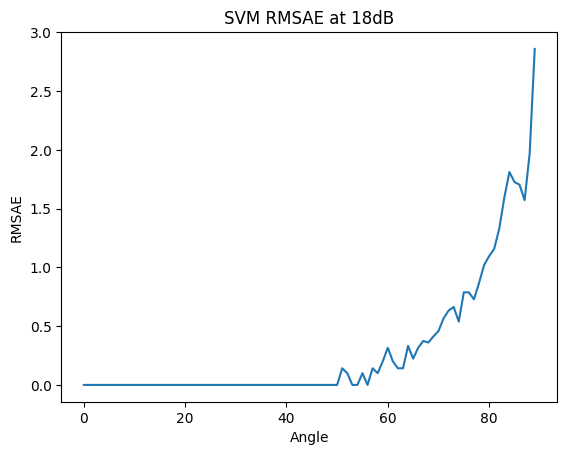

In [26]:
plt.title(f"SVM RMSAE at {arrClass.snr}dB")
plt.xlabel("Angle")
plt.ylabel("RMSAE")
plt.plot(x,y)

In [66]:
arrClass = ArrClass()
arrClass.samps = 12000
arrClass.fs = 101
arrClass.numAntenna = 5
dimm = 5
x,y = genSweep(arrClass, dimm)
print(x.shape, y.shape)
arrClass.samps = 1200
test_x, test_y = genSweep(arrClass, dimm)
mlpclf = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(31, 31, 31, 31), random_state=1))
mlpclf.fit(x,y)
print(mlpclf)
print(sklearn.metrics.accuracy_score(test_y, mlpclf.predict(test_x)))


(1080000, 10) (1080000,)


/home/danderson/vt/ece_5674/DirectionFinderSim/sklearn-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])
0.8710555555555556


In [67]:
arrClass.snr = 18
x,y = genWaveTest(arrClass, mlpclf.predict, dimm)

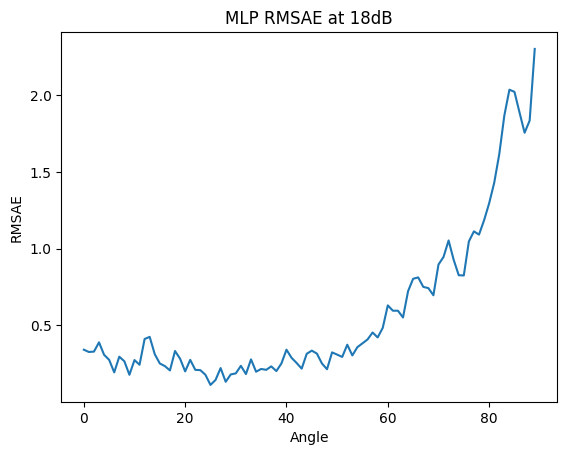

In [70]:
plt.title(f"MLP RMSAE at {arrClass.snr}dB")
plt.xlabel("Angle")
plt.ylabel("RMSAE")
plt.plot(x,y)

In [12]:
arrClass = ArrClass()
arrClass.samps = 1200
arrClass.fs = 101
arrClass.numAntenna = 5
dimm = 5
x,y = genSweep(arrClass, dimm)
print(x.shape, y.shape)
arrClass.samps = 120
test_x, test_y = genSweep(arrClass, dimm)
clf = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), LinearRegression())
clf.fit(x,y)
print(clf)
# print(sklearn.metrics.accuracy_score(test_y, clf.predict(test_x)))


(108000, 10) (108000,)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
[44.502518824969165, 43.49803368925281, 42.49978772794053, 41.50031127779684, 40.50021460221143, 39.49970297678814, 38.499913310171394, 37.50049197962651, 36.49982132172433, 35.50225641933097, 34.49890624463049, 33.50110379274694, 32.500800273670514, 31.49991949074786, 30.49939955575631, 29.499432526187164, 28.500157037601127, 27.499941218678927, 26.49988532847629, 25.499512764716982, 24.499212454507592, 23.50081375304403, 22.500514770659915, 21.500326953268317, 20.499314233137994, 19.500749639406926, 18.500150326246207, 17.50047867508653, 16.499413085733238, 15.498675028718234, 14.499283432862013, 13.500053081497308, 12.501301419308758, 11.

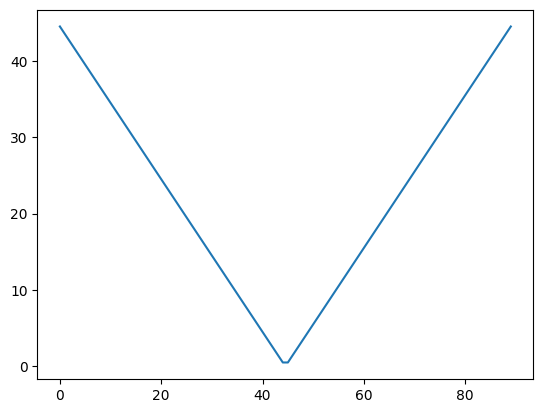

In [13]:
x,y = genWaveTest(arrClass, clf.predict, dimm)
print(x)
print(y)
plt.plot(x,y)


In [71]:
arrClass = ArrClass()
arrClass.fs = 101
arrClass.numAntenna = 5
arrClass.samps = 120
arrClass.snr = 20
dimm = 5
def bartlett(inputVec):
    output = []
    for i in range(len(inputVec[0])//5):
        power = []
        sig = np.matrix(inputVec[:,i*5:(i+1)*5])
        angles = np.linspace(0, .5, 90) * np.pi
        out = np.zeros(90)
        # sig = np.squeeze(np.matrix(np.asanyarray(inputVec)[:, i, :]))
        r = sig @ sig.H
        for theta in angles:
            a = np.matrix(np.exp(-1j*np.pi*np.arange(5)*np.sin(theta)))
            b = np.conj(a) @ r @ a.T
            power.append(np.mean(20*np.log10(np.abs(b))))
        output.append(np.argmax(power))
    return np.array(output)
        



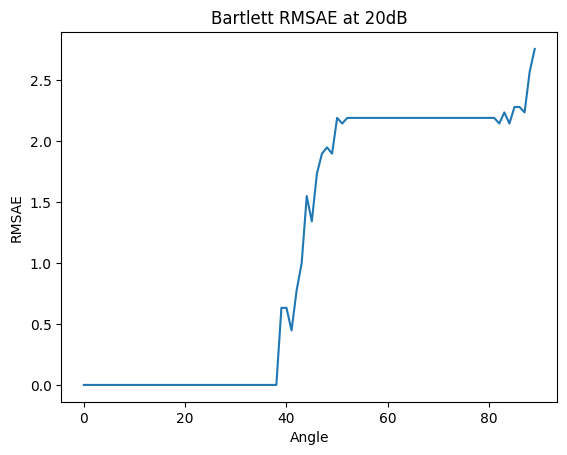

In [72]:
x,y = genAlgWaveTest(arrClass, bartlett, dimm)
plt.title(f"Bartlett RMSAE at {arrClass.snr}dB")
plt.xlabel("Angle")
plt.ylabel("RMSAE")
plt.plot(x,y)

In [88]:

arrClass = ArrClass()
arrClass.fs = 101
arrClass.numAntenna = 5
arrClass.samps = 120
arrClass.snr = 20
dimm = 5
def capon(inputVec):
    output = []
    for i in range(len(inputVec[0])//5):
        power = []
        sig = np.matrix(inputVec[:,i*5:(i+1)*5])
        angles = np.linspace(0, .5, 90) * np.pi
        out = np.zeros(90)
        # sig = np.squeeze(np.matrix(np.asanyarray(inputVec)[:, i, :]))
        r = sig @ sig.H
        r = np.linalg.inv(r)
        for theta in angles:
            a = np.matrix(np.exp(-1j*np.pi*np.arange(5)*np.sin(theta)))
            b = np.conj(a) @ r @ a.T
            power.append(np.mean(20*np.log10(np.abs(1/b))))
        output.append(np.argmax(power))
    return np.array(output)

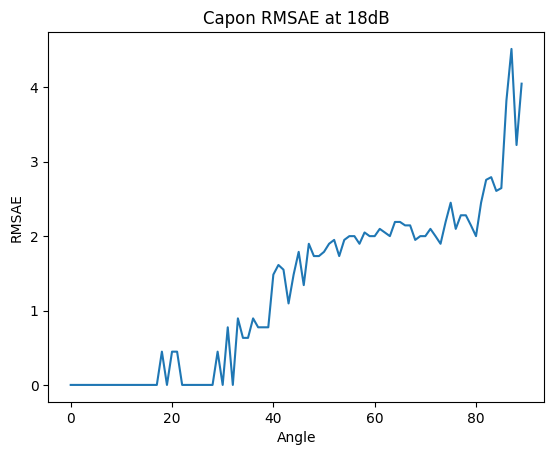

In [89]:
x,y = genAlgWaveTest(arrClass, capon, dimm)
plt.title(f"Capon RMSAE at {arrClass.snr}dB")
plt.xlabel("Angle")
plt.ylabel("RMSAE")
plt.plot(x,y)

In [86]:
arrClass = ArrClass()
arrClass.fs = 101
arrClass.numAntenna = 5
arrClass.samps = 120
arrClass.snr = 18
dimm = 5
def MUSIC(inputVec):
    output = []
    for i in range(len(inputVec[0])//5):
        power = []
        sig = np.matrix(inputVec[:,i*5:(i+1)*5])
        angles = np.linspace(0, .5, 90) * np.pi
        out = np.zeros(90)
        # sig = np.squeeze(np.matrix(np.asanyarray(inputVec)[:, i, :]))
        r = sig @ sig.H
        eigen_val, eigen_vec = np.linalg.eig(r)
        eigen_val_sort = np.argsort(np.abs(eigen_val))
        eigen_vec = eigen_vec[:, eigen_val_sort]
        eigen_vec_remain = np.asmatrix(np.zeros((5, 5 - 1), dtype=np.complex128))
        for i in range(4):
            eigen_vec_remain[:,i] = eigen_vec[:,i]
        for theta in angles:
            a = np.matrix(np.exp(-1j*np.pi*np.arange(5)*np.sin(theta))).T
            p = 1 / (a.H @ eigen_vec_remain @ eigen_vec_remain.H @ a)
            power.append(np.mean(20*np.log10(np.abs(p[0,0]))))
        output.append(np.argmax(power))
    return np.array(output)


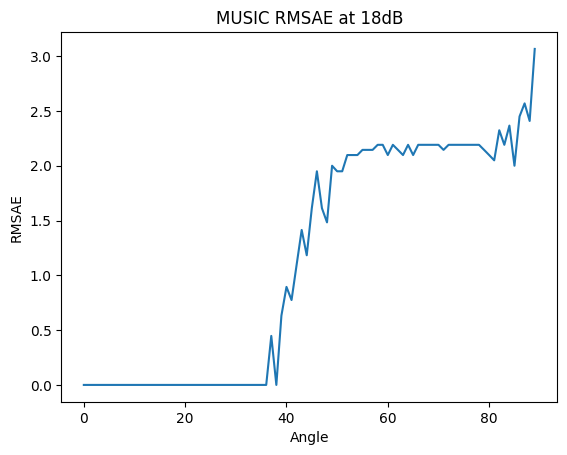

In [87]:

x,y = genAlgWaveTest(arrClass, MUSIC, dimm)
plt.title(f"MUSIC RMSAE at {arrClass.snr}dB")
plt.xlabel("Angle")
plt.ylabel("RMSAE")
plt.plot(x,y)